# Assignment 2

## Part A. Document Clustering

III. Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

In [24]:
# install.packages('tm', repos = "http://cran.us.r-project.org")
# install.packages('SnowballC', repos = "http://cran.us.r-project.org")

In [2]:
# Import libraries
options(warn=-1)
library(tm)
library(SnowballC)

### Reading the data
**INPUTS:**
    # file.name: name of the input .txt file
    # sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
    # seed: random seed for sampling (read above)
    # pre.proc: if TRUE performs the preprocessing (recommended)
    # spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
**OUTPUTS:**
    # docs: the unlabled corpus (each row is a document)
    # word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
    # label: the real cluster labels (will be used in visualization/validation and not for clustering)

In [26]:
# reading the data
read.data <- function(file.name='Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
    
    # Read the data
    text <- readLines(file.name)
    # select a subset of data if sample.size > 0
    if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
    }
    ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
    docs <- strsplit(text, '\t')
    # store the labels for evaluation
    labels <-  unlist(lapply(docs, function(x) x[1]))
    # store the unlabeled texts    
    docs <- data.frame(sentence = c(unlist(lapply(docs, function(x) x[2]))))


    # create a corpus
    corp <- Corpus(VectorSource(docs$sentence))

    # Preprocessing:
    if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
    }  
    # Create a matrix which its rows are the documents and colomns are the words. 
    dtm <- DocumentTermMatrix(corp)
    ## reduce the sparcity of out dtm
    dtm <- removeSparseTerms(dtm, spr.ratio)
    ## convert dtm to a matrix
    word.doc.mat <- t(as.matrix(dtm))

    # Return the result
    return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

### Helper function

#### Input:    logA1, logA2 ... logAn
#### Output:   log(A1+A2+...+An)

<br>

This function is needed to prevent numerical overflow/underflow when working with small numbers, because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   

<br>
Example: 
Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities in [0,1].
To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function. 
Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)].
Then get the results by: exp(logSum(v))

In [27]:
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [28]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

### E Step for Soft Document Clustering

In [29]:
# this function currently implements the E-step of the soft-EM
E_soft.step <- function(gamma, model, counts){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    # E step:    
    for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    }

    # converting back from the log space 
    gamma <- exp(gamma)

    return (gamma)
}

### E Step for Hard Document Clustering 

In [30]:
# this function currently implements the E-step of the hard-EM
#
E_hard.step <- function(gamma, model, counts){
    # Model Parameter Setting
    N <- dim(counts)[2] # number of documents
    K <- dim(model$mu)[1]

    # E step:    
    for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    }

    # converting back from the log space 
    gamma <- exp(gamma)
    
    # hard assignments:
    max.prob <- gamma ==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
    gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
    gamma[!max.prob] <- 0 # remove points from clusters with lower probabilites

    return (gamma)
}

### M Step for Document Clustering

**Note:** M-step for both hard and soft document clustering is the same.

In [31]:
M.step <- function(gamma, model, counts){
    # Model Parameter Setting
    N <- dim(counts)[2]   # number of documents
    W <- dim(counts)[1]   # number of words i.e. vocabulary size
    K <- dim(model$mu)[1] # number of clusters
 
    # M step:
    # for rho
    for (k in 1:K){
        # the relative cluster size  
        model$rho[k,1] <- sum(gamma[,k])/N       
    }
    
    # for mu
    for (k in 1:K){
        # initialze numerator of mu for each cluster (K) to 0
        num = 0
        
        # For every document
        for (n in 1:N){
            
            # numerator of mu = sum of (posterior prob (gamma) of each document in the cluster) X (each words in the document)
            num = num + gamma[n,k] * counts[,n]
        }
        
        # add a small number (eps = 1e-10)
        num = num + 1e-10
        
        # Probablity of each work occuring in a document assigned to cluster k 
        model$mu[k,] <- num/sum(num)
        
    }  
    

    # Return the result
    return (model)
}

### The training objective function
**Input:**
    #    model:  the model object containing the mu and rho
    #    counts: the word-document frequency matrix
**Output:**
    #    nloglike: the negative log-likelihood i.e. log P(counts|model) 

In [32]:
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### EM for Soft Document Clustering

**INPUTS:**
      #counts: word count matrix
      #K: the number of clusters
**OUTPUTS:**
      #model: a list of model parameters

In [33]:
EM_soft <- function(counts, K=4, max.epoch=10, seed=123456){
    
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  # Build the model
  for(epoch in 1:max.epoch){
    
    # E- Soft Step
    gamma <- E_soft.step(gamma, model, counts)
    
    # M Step
    model <- M.step(gamma, model, counts)
   
    #print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

### EM for Hard Document Clustering

**INPUTS:**
      #counts: word count matrix
      #K: the number of clusters
**OUTPUTS:**
      #model: a list of model parameters

In [34]:
EM_hard <- function(counts, K=4, max.epoch=10, seed=123456){
    
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)
    
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E- Soft Step
    gamma <- E_hard.step(gamma, model, counts)
    
    # M Step
    model <- M.step(gamma, model, counts)
   
    #print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

In [35]:
##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

### Main body 
IV. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

#### Reading documents 
**Note:** sample.size=0 means all read all documents!
<br>          (for develiopment and debugging use a smaller subset e.g., sample.size = 40)

In [42]:
options(warn=-1)

# Read data
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        

# calling the EM Soft algorithm on the data
res_soft <- EM_soft(counts, K=4, max.epoch=5)   

# calling the EM Hard algorithm on the data
res_hard <- EM_hard(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability 
label_soft.hat <- apply(res_soft$gamma, 1, which.max) 

label_hard.hat <- apply(res_hard$gamma, 1, which.max) 

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

V. Perform a PCA on the data you clustered using the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualise the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Save your visualizations as plots and include them in your jupyter notebook.

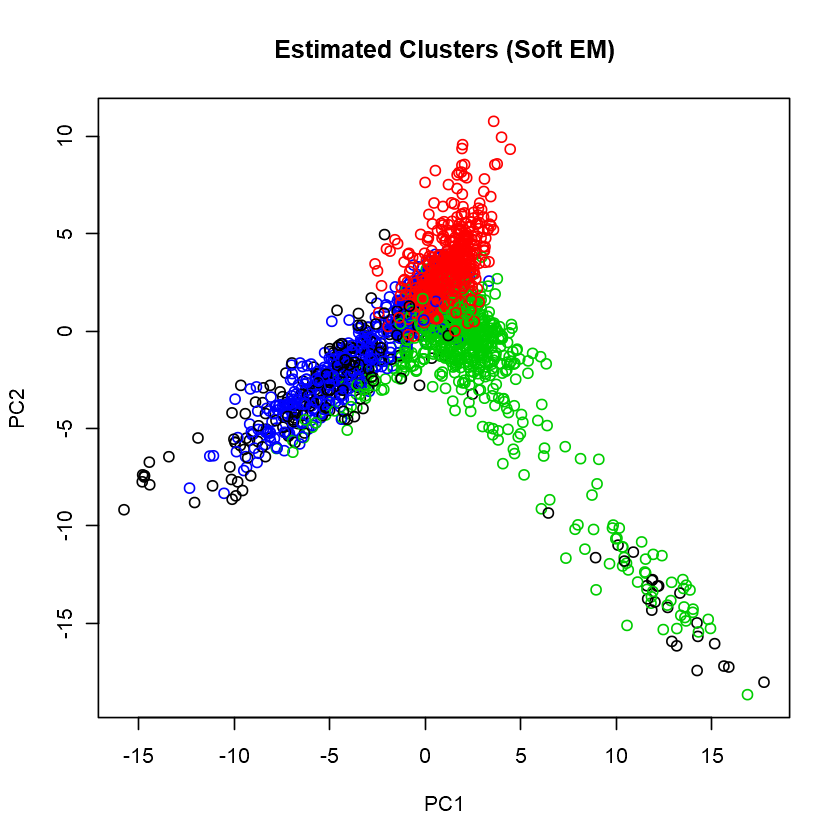

In [43]:
## visualize the estimated clusters for Soft Document Clustering
cluster.viz(t(counts), label_soft.hat, 'Estimated Clusters (Soft EM)')

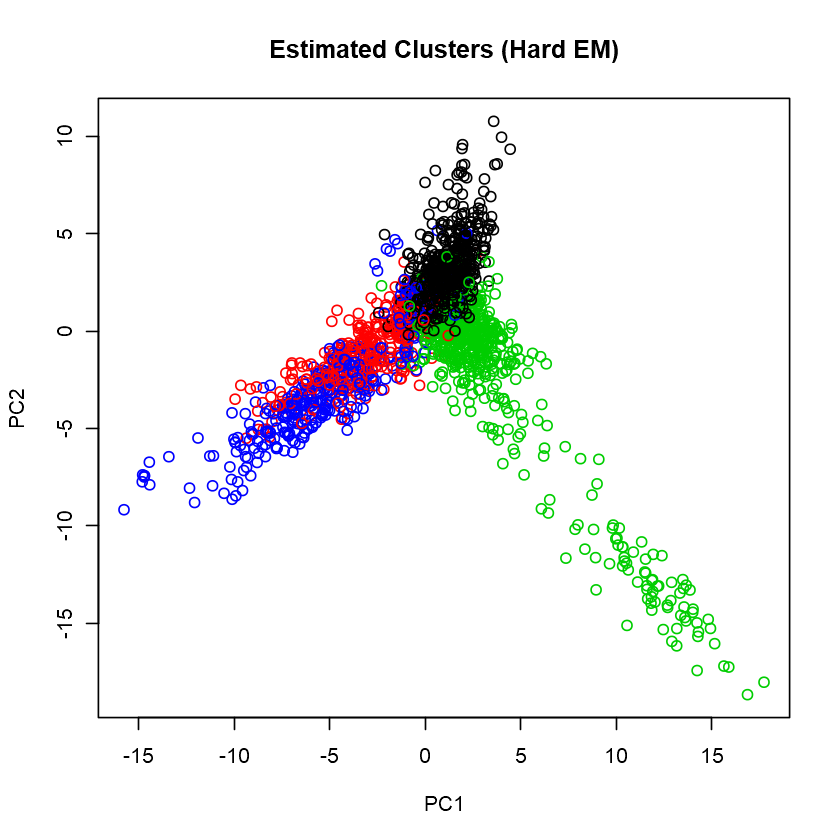

In [15]:
## visualize the estimated clusters for Hard Document Clustering
cluster.viz(t(counts), label_hard.hat, 'Estimated Clusters (Hard EM)')

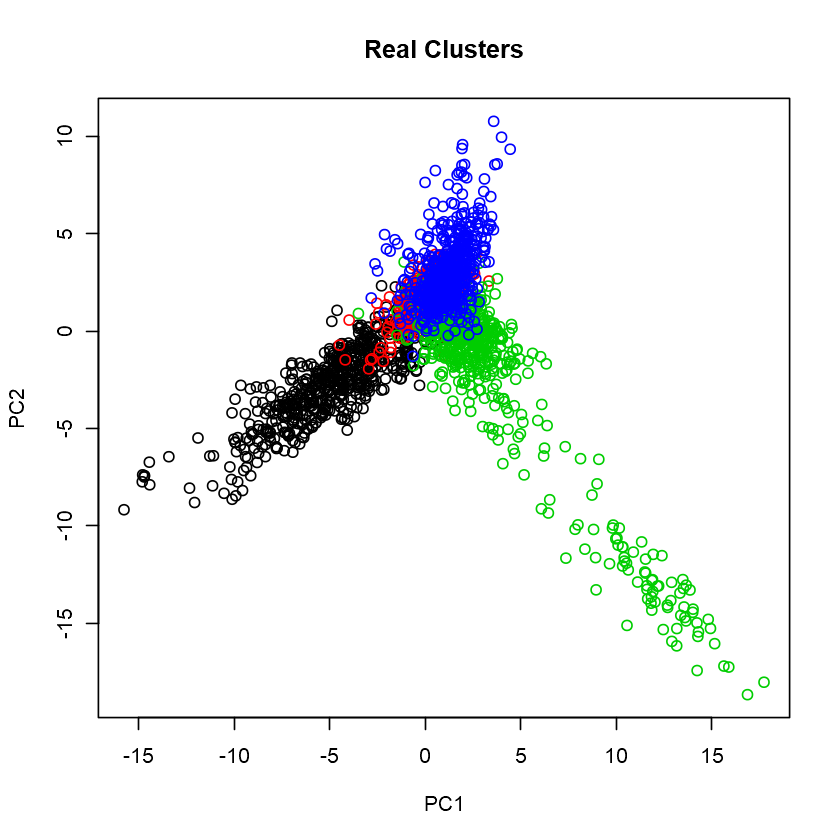

In [16]:
## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')